In [ ]:
%reset

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as pl
import seaborn as sns

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,roc_curve, auc, metrics
from sklearn.feature_selection import RFE

/Users/agata/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/agata/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:4: DeprecationWarning: sklearn.metrics.metrics is deprecated and will be removed in 0.18. Please import from sklearn.metrics
  DeprecationWarning)


# Load Dataframe

In [5]:
# Load the final data frame. This dataframe should contain only the final records to be tested (subsampled for 
# over-represented individuals), with each column containing a feature, and one column containing information about
# Parkinson's diagnosis (a boolean with 0=no diagnosis and 1=PD diagnosis)

model_df = pd.read_pickle('finalfeatures_df')

# Scale (center and normalize) feature dataframe 

In [28]:
# Take the diagnosis information as its own array, and center and normalize the remaining feautures.

y = np.ravel(model_df['condition'])
features = model_df.drop(['condition'], axis=1)
cols =  features.columns

features_scaled = preprocessing.scale(features)
X = pd.DataFrame(features_scaled,columns=cols)

# Grid search

In [29]:
# Run a logistic regression model with 5-fold train-test split, using grid seaech with L2 regularization to find the optimal
# parameters for the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)

parameters = {'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 1000] }
logreg = LogisticRegression(penalty='l2')#,class_weight = 'balanced')
clf = GridSearchCV(logreg, parameters)
clf.fit(X_train,y_train)
clf = clf.best_estimator_
print clf.score(X_test,y_test)

0.654411764706


# Model outputs

In [31]:
# Predict accuracy of the trained model on the reserved test set
predicted = clf.predict(X_test)

In [32]:
# Draw a confusion matrix of the results of testing the trained model on the reserved test set

pd.crosstab(y_test,predicted,rownames=['True'],colnames=['False'],margins=True)

False,0,1,All
True,,,
0,50,30,80
1,17,39,56
All,67,69,136


In [33]:
# Look at other measures of predicitve power

print clf.score(X_train,y_train)
print clf.score(X_test,y_test)
print f1_score(y_test,predicted)

0.69557195572
0.654411764706
0.624
0.310612597066


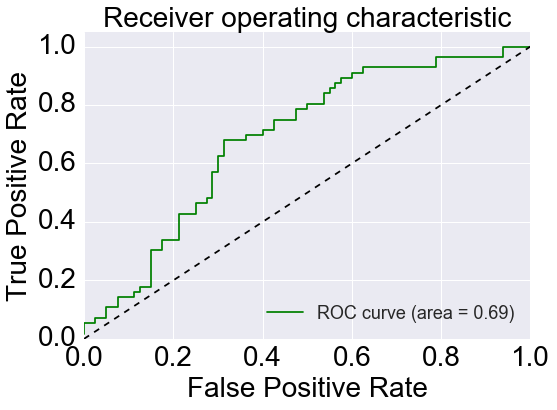

In [34]:
# Compute ROC curve and ROC area

y_score = clf.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

##############################################################################
# Plot ROC curve
pl.figure()
pl.plot(fpr, tpr, 'g',label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.05])
pl.xticks(color = 'k', size = 28)
pl.yticks(color = 'k', size = 28)
pl.xlabel('False Positive Rate',{'color':'k','fontsize': 28})
pl.ylabel('True Positive Rate',{'color':'k','fontsize': 28})
pl.title('Receiver operating characteristic',{'color':'k','fontsize': 28})
pl.legend(loc="lower right",fontsize= 18)
pl.show()

# Recursive Feature Elimination

In [35]:
# Identify most important features by eliminating features from the data 

# create the RFE model and select 5 attributes
featurenum = 5
rfe = RFE(clf, featurenum)
rfe = rfe.fit(X_train,y_train)

# summarize the selection of the attributes
support = rfe.support_
ranking = rfe.ranking_

strongfeatures = cols[support]
print strongfeatures